### Student Information
Name: Danny（蕭擎軒）

Student ID: 108164701

GitHub ID: wuling31715

Kaggle name: Danny

Kaggle private scoreboard snapshot:

![Kaggle](pics/kaggle.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2020-Lab2-Master Repo](https://github.com/fhcalderon87/DM2020-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/c/dm2020-hw2-nthu/) regarding Emotion Recognition on Twitter. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the score (ie. 20% of 30% )

    - **Top 41% - 100%**: Get (101-x)% of the score, where x is your ranking in the leaderboard (ie. (101-x)% of 30% )   
    Submit your last submission __BEFORE the deadline (Dec. 5th 11:59 pm, Saturday)__. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


You can submit your homework following these guidelines: [Git Intro & How to hand your homework](https://github.com/fhcalderon87/DM2020-Lab1-Master/blob/master/Git%20Intro%20%26%20How%20to%20hand%20your%20homework.ipynb), but make sure to fork the [DM2020-Lab2-Homework](https://github.com/fhcalderon87/DM2020-Lab2-Homework) repository this time! Also please __DON´T UPLOAD HUGE DOCUMENTS__, please use Git ignore for that.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 8th 11:59 pm, Tuesday)__. 

# Data Mining Lab 2
In this lab session we will focus on the use of Neural Word Embeddings 

## Table of Contents
1. Data preparation
2. Feature engineering
3. Model
4. Results evaluation
5. Other things you could try
6. Deep Learning
7. Word to Vector
8. Clustering
9. High-dimension Visualization



### Necessary Library Requirements:

#### Same as Lab1:
- [Jupyter](http://jupyter.org/) (Strongly recommended but not required)
    - Install via `pip3 install jupyter` and use `jupyter notebook` in terminal to run
- [Scikit Learn](http://scikit-learn.org/stable/index.html)
    - Install via `pip3 sklearn` from a terminal
- [Pandas](http://pandas.pydata.org/)
    - Install via `pip3 install pandas` from a terminal
- [Numpy](http://www.numpy.org/)
    - Install via `pip3 install numpy` from a terminal
- [Matplotlib](https://matplotlib.org/)
    - Install via `pip3 maplotlib` from a terminal
- [Plotly](https://plot.ly/)
    - Install via `pip3 install plotly` from a terminal
- [Seaborn](https://seaborn.pydata.org/)
    - Install and signup for `seaborn`
- [NLTK](http://www.nltk.org/)
    - Install via `pip3 install nltk` from a terminal
    
#### New Libraries to intsall:
- [Gensim](https://pypi.org/project/gensim/)
    - Install via `pip3 install gensim`
- [tensorflow](https://www.tensorflow.org/)
    - Install via `pip3 install tensorflow=1.15`
    - Also install `pip3 install tensorflow-hub`
- [Keras](https://keras.io/)
    - Install via `pip3 install keras`
    
                                                                                            
                                                                                           

---
## Introduction

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embedding and other deep information retrieval approaches.

![pic0](pics/pic0.png)

---
## 1. Data Preparation

Before beggining the lab, please make sure to download the [Google News Dataset](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) and place it in a folder named "GoogleNews" in the same directory as this file.

## 1.1 Load data

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [3]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [4]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [5]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [6]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


In [7]:
# Answer here
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
def get_term_frequencies(matrix):
    term_freq = list()

    for t in matrix.T:
        term_freq.append(t.toarray().sum())

    return term_freq

In [9]:
def plot_word_frequency(N, text_df):
    vectorizer = CountVectorizer(max_features=N)
    matrix = vectorizer.fit_transform(text_df)

    index = np.arange(N)

    term_freq = get_term_frequencies(matrix)
    term_freq_list = list()

    for i in np.argsort(term_freq)[::-1]:
        term_freq_list.append(vectorizer.get_feature_names()[i])
    y = np.sort(term_freq)[::-1]

    fig = plt.figure(figsize=(9, 6))
    ax = fig.subplots()

    ax.set_title('Top 30 Term')
    ax.barh(index, y, align='center')
    ax.set_yticks(index)
    ax.set_yticklabels(term_freq_list)
    ax.invert_yaxis()

    fig.tight_layout()
    plt.show()

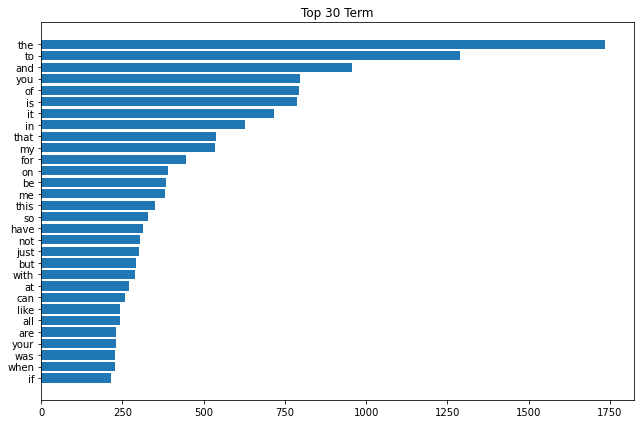

In [10]:
plot_word_frequency(30, train_df['text'])

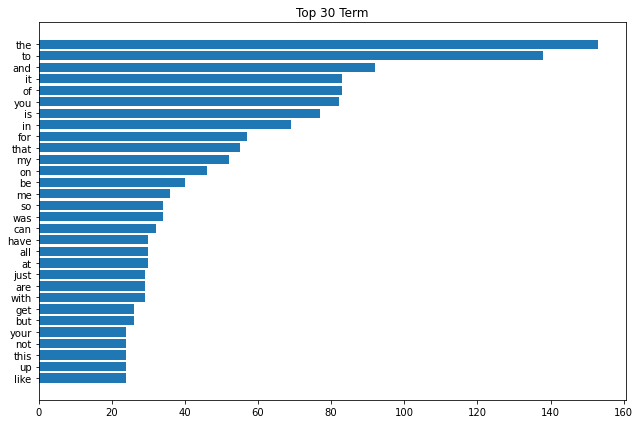

In [11]:
plot_word_frequency(30, test_df['text'])

---
### 1.2 Save data

We will save our data in Pickle format. The pickle module implements binary protocols for serializing and de-serializing a Python object structure.   
  
Some advantages for using pickle structure:  
* Because it stores the attribute type, it's more convenient for cross-platform use.  
* When your data is huge, it could use less space to store also consume less loading time.   

In [12]:
## save to pickle file
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

In [13]:
## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---
### 1.3 Exploratory data analysis (EDA)

Again, before getting our hands dirty, we need to explore a little bit and understand the data we're dealing with.

In [14]:
#group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger       857
fear       1147
joy         823
sadness     786
Name: text, dtype: int64

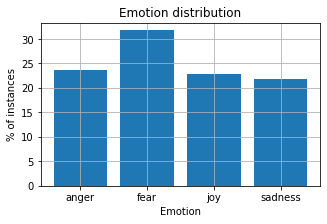

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

---

## 2. Feature engineering
### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 

In [18]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

In [19]:
# check the result
train_data_BOW_features

<3613x10115 sparse matrix of type '<class 'numpy.int64'>'
	with 51467 stored elements in Compressed Sparse Row format>

In [20]:
type(train_data_BOW_features)

scipy.sparse.csr.csr_matrix

In [21]:
# add .toarray() to show
train_data_BOW_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
# check the dimension
train_data_BOW_features.shape

(3613, 10115)

In [23]:
# observe some feature names
feature_names = BOW_vectorizer.get_feature_names()
feature_names[100:110]

['2k17', '2much', '2nd', '30', '300', '301', '30am', '30pm', '30s', '31']

The embedding is done. We can technically feed this into our model. However, depending on the embedding technique you use and your model, your accuracy might not be as high, because:

* curse of dimensionality  (we have 10,115 dimension now)
* some important features are ignored (for example, some models using emoticons yeld better performance than counterparts)

In [24]:
"😂" in feature_names

False

Let's try using another tokenizer below.

In [25]:
import nltk
# nltk.download()

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

## check dimension
train_data_BOW_features_500.shape

/home/Danny/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(3613, 500)

In [26]:
train_data_BOW_features_500.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 4, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names()
feature_names_500[100:110]

['change',
 'cheer',
 'cheerful',
 'cheerfully',
 'cheering',
 'cheery',
 'come',
 'comes',
 'could',
 'country']

In [28]:
"😂" in feature_names_500

True

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [29]:
# Answer here
from sklearn.feature_extraction.text import TfidfVectorizer

N = 1000
TFIDF_1000 = TfidfVectorizer(max_features=N, tokenizer=nltk.word_tokenize)

TFIDF_1000.fit(train_df['text'])
train_data_TFIDF_1000 = TFIDF_1000.transform(train_df['text'])

train_data_TFIDF_1000.shape

/home/Danny/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(3613, 1000)

In [30]:
feature_names_1000 = TFIDF_1000.get_feature_names()
feature_names_1000[100:110]

['awareness',
 'away',
 'awe',
 'awesome',
 'awful',
 'b',
 'baby',
 'back',
 'bad',
 'ball']

---
## 3. Model
### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [31]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habbit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [32]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=0)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['joy', 'anger', 'fear', 'sadness', 'fear', 'anger', 'anger',
       'fear', 'anger', 'anger'], dtype=object)

---
## 4. Results Evaluation

Now we will check the results of our model's performance

In [33]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

training accuracy: 0.99
testing accuracy: 0.67


In [34]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.64      0.67      0.65        84
        fear       0.65      0.72      0.68       110
         joy       0.68      0.68      0.68        79
     sadness       0.72      0.58      0.64        74

    accuracy                           0.67       347
   macro avg       0.67      0.66      0.67       347
weighted avg       0.67      0.67      0.67       347



In [35]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[56 16  7  5]
 [16 79  9  6]
 [ 5 14 54  6]
 [10 12  9 43]]


In [36]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

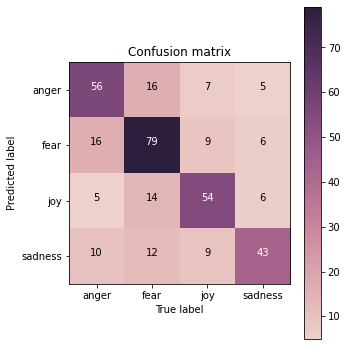

In [37]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

### Answer here
In the above results, we found out that the training accuracy is 0.99; however, the testing accuracy is 0.67. Hence, the Decision Tree model is overfitting.

---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [38]:
# Answer here
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])
train_data_BOW_features_500.shape

/home/Danny/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(3613, 500)

In [39]:
from sklearn.naive_bayes import MultinomialNB

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habbit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [40]:
NB_model = MultinomialNB()
NB_model = NB_model.fit(X_train, y_train)

# get predicted result on test data
y_train_pred = NB_model.predict(X_train)
y_test_pred = NB_model.predict(X_test)

In [41]:
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

training accuracy: 0.79
testing accuracy: 0.71


In [42]:
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.65      0.65      0.65        84
        fear       0.74      0.81      0.77       110
         joy       0.79      0.71      0.75        79
     sadness       0.65      0.62      0.63        74

    accuracy                           0.71       347
   macro avg       0.71      0.70      0.70       347
weighted avg       0.71      0.71      0.71       347



---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

### Answer here

* Decision Tree: Overfitting is a significant practical difficulty for decision tree models and many other predictive models. Overfitting happens when the learning algorithm continues to develop hypotheses that reduce training set error at the cost of an
increased test set error.

* Naive Bayes classifier: The Naive Bayes classifier employs a very simple (linear) hypothesis function. On the other hand, it exhibits low variance or failure to generalize to unseen data based on its training set, because it's hypothesis class' simplicity prevents it from overfitting to its training data.

* [Why Decision Tree will overfitting?](https://www.saedsayad.com/decision_tree_overfitting.htm)

* [Quora: Why are Naive Bayes classifiers considered relatively immune to overfitting?](https://www.quora.com/Why-are-Naive-Bayes-classifiers-considered-relatively-immune-to-overfitting)


---

## 5. Other things you can try

Thus, there are several things you can try that will affect your results. In order to yield better results, you can experiment by: 
    * Trying different features (Feature engineering)
        -Eg. Word2Vec,PCA,LDA,FastText, Clustering......
    * Trying different models
    * Analyzing your results and interpret them to improve your feature engineering/model building process
    * Iterate through the steps above until finding a satisfying result
Remember that you should also consider the task at hand and the model you'll feed the data to. 

---
## 6. Deep Learning

We use [Keras](https://keras.io/) to be our deep learning framwork, and follow the [Model (functional API)](https://keras.io/models/model/) to build a Deep Neural Network (DNN) model. Keras runs with Tensorflow in the backend. It's a nice abstraction to start working with NN models. 

Because Deep Learning is a 1-semester course, we can't talk about each detail about it in the lab session. Here, we only provide a simple template about how to build & run a DL model successfully. You can follow this template to design your model.

We will begin by building a fully connected network, which looks like this:

![Fully Connected Network](pics/pic1.png)

(source: https://github.com/drewnoff/spark-notebook-ml-labs/tree/master/labs/DLFramework)


### 6.1 Prepare data (X, y)

In [43]:
import keras

# standardize name (X, y) 
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


### 6.2 Deal with categorical label (y)

Rather than put your label `train_df['emotion']` directly into a model, we have to process these categorical (or say nominal) label by ourselves. 

Here, we use the basic method [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our categorical  labels to numerical ones.


In [44]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 373       anger
3210    sadness
1114       fear
88        anger
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


### 6.3 Build model

In [45]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


![Imgur](pics/pic2.png)

In [46]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                32064     
_________________________________________________________________
re_lu (ReLU)                 (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
_________________________________________________________________
softmax (Softmax)            (None, 4)                

### 6.4 Train

In [47]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25
113/113 [==============================] - 0s 3ms/step - loss: 1.3257 - accuracy: 0.3670 - val_loss: 1.2816 - val_accuracy: 0.4496
Epoch 2/25
113/113 [==============================] - 0s 2ms/step - loss: 0.9862 - accuracy: 0.6609 - val_loss: 0.9106 - val_accuracy: 0.6772
Epoch 3/25
113/113 [==============================] - 0s 2ms/step - loss: 0.5731 - accuracy: 0.7991 - val_loss: 0.7681 - val_accuracy: 0.7003
Epoch 4/25
113/113 [==============================] - 0s 2ms/step - loss: 0.4057 - accuracy: 0.8519 - val_loss: 0.7749 - val_accuracy: 0.6916
Epoch 5/25
113/113 [==============================] - 0s 2ms/step - loss: 0.3161 - accuracy: 0.8860 - val_loss: 0.7784 - val_accuracy: 0.7003
Epoch 6/25
113/113 [==============================] - 0s 2ms/step - loss: 0.2552 - accuracy: 0.9153 - val_loss: 0.8571 - val_accuracy: 0.6801
Epoch 7/25
113/113 [==============================] - 0s 2ms/step - loss: 0.2070 - accuracy: 0.9316 - val_loss: 0.9245 - val_accuracy: 0.6744
Epoch 

### 6.5 Predict on testing data

In [48]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

array([[2.9558486e-03, 7.8032845e-01, 2.1251044e-01, 4.2052465e-03],
       [9.9919409e-01, 1.3682443e-08, 5.2175874e-06, 8.0075255e-04],
       [8.6924367e-02, 2.9228676e-02, 5.6756914e-02, 8.2708997e-01],
       [2.8055746e-07, 1.6595929e-07, 1.1295858e-10, 9.9999952e-01],
       [7.9905130e-02, 8.8966995e-01, 1.5460779e-05, 3.0409519e-02]],
      dtype=float32)

In [49]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['fear', 'anger', 'sadness', 'sadness', 'fear'], dtype=object)

In [50]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.66


In [51]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.367008,1.325655,0.449568,1.281552
1,1,0.660947,0.986157,0.677233,0.910634
2,2,0.799059,0.573112,0.700288,0.768136
3,3,0.851924,0.405692,0.691643,0.774915
4,4,0.885967,0.316129,0.700288,0.778403
5,5,0.915306,0.255155,0.680115,0.857100
6,6,0.931636,0.207025,0.674352,0.924467
7,7,0.948242,0.173755,0.674352,0.985431
8,8,0.954885,0.146557,0.671470,1.035307
9,9,0.961805,0.124278,0.674352,1.082711


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below (Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="pics/pic3.png" style="width: 300px;"/> </td>
    <td><img src="pics/pic4.png" style="width: 300px;"/> </td>
</tr></table>

In [52]:
# Answer here
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.367008,1.325655,0.449568,1.281552
1,1,0.660947,0.986157,0.677233,0.910634
2,2,0.799059,0.573112,0.700288,0.768136
3,3,0.851924,0.405692,0.691643,0.774915
4,4,0.885967,0.316129,0.700288,0.778403


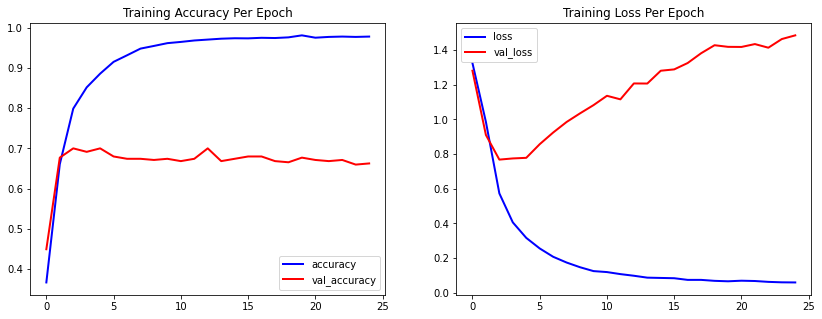

In [53]:
plt.figure(figsize=(14, 5))

# plot training and validation accuracy per epoch
plt.subplot(121)
plt.plot('epoch', 'accuracy', data=training_log, marker='', color='b', linewidth=2)
plt.plot('epoch', 'val_accuracy', data=training_log , marker='', color='r', linewidth=2)
plt.title('Training Accuracy Per Epoch')
plt.legend()

# plot training and validation loss per epoch
plt.subplot(122)
plt.plot('epoch', 'loss', data=training_log, marker='', color='b', linewidth=2)
plt.plot('epoch', 'val_loss', data=training_log , marker='', color='r', linewidth=2)
plt.title('Training Loss Per Epoch')
plt.legend()

plt.show()

---

### Note

If you don't have a GPU (level is higher than GTX 1060) or you are not good at setting lots of things about computer, we recommend you to use the [kaggle kernel](https://www.kaggle.com/kernels) to do deep learning model training. They have already installed all the librarys and provided free GPU for you to use.

Note however that you will only be able to run a kernel for 6 hours. After 6 hours of inactivity, your Kaggle kernel will shut down (meaning if your model takes more than 6 hours to train, you can't train it at once).


### More Information for your reference

* Keras document: https://keras.io/
* Keras GitHub example: https://github.com/keras-team/keras/tree/master/examples
* CS229: Machine Learning: http://cs229.stanford.edu/syllabus.html
* Deep Learning cheatsheet: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning
* If you want to try TensorFlow or PyTorch: https://pytorch.org/tutorials/
https://www.tensorflow.org/tutorials/quickstart/beginner

---
## 7. Word2Vector

We will introduce how to use `gensim` to train your word2vec model and how to load a pre-trained model.

https://radimrehurek.com/gensim/index.html

### 7.1 Prepare training corpus

In [54]:
## check library
import gensim

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
373,10373,Candice's pout gets more preposterous by the w...,"[Candice, 's, pout, gets, more, preposterous, ..."
3210,40383,236:416 While she was in her dull and sleeping...,"[236:416, While, she, was, in, her, dull, and,..."
1114,20257,@SadiqKhan #terrorism shouldn't be a way of li...,"[@, SadiqKhan, #, terrorism, should, n't, be, ..."
88,10088,Bes! You don't just tell a true blooded hoopju...,"[Bes, !, You, do, n't, just, tell, a, true, bl..."
3383,40556,#ThankYouCGI - Do not grow weary in doing good...,"[#, ThankYouCGI, -, Do, not, grow, weary, in, ..."


In [55]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['Candice', "'s", 'pout', 'gets', 'more', 'preposterous', 'by', 'the', 'week', '.', 'This', 'week', 'it', "'s", 'gone', 'a', 'bit', 'Jack', 'Nicholson', "'s", 'Joker', '.', '#', 'GBBO']),
       list(['236:416', 'While', 'she', 'was', 'in', 'her', 'dull', 'and', 'sleeping', 'hour', ',', '\\nA', 'crew', 'of', 'patches', ',', 'rude', 'mechanicals', ',', '\\n', '#', 'AMNDBots']),
       list(['@', 'SadiqKhan', '#', 'terrorism', 'should', "n't", 'be', 'a', 'way', 'of', 'life', 'in', 'the', 'united', 'etates', 'and', 'was', "n't", 'until', '#', 'islam', 'brought', 'it', 'here', '!', '#', 'IslamExposed', '#', 'islambacon'])],
      dtype=object)

### 7.2 Training our model

You can try to train your own model. More details: https://radimrehurek.com/gensim/models/word2vec.html

In [56]:
## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
373,10373,Candice's pout gets more preposterous by the w...,"[Candice, 's, pout, gets, more, preposterous, ..."
3210,40383,236:416 While she was in her dull and sleeping...,"[236:416, While, she, was, in, her, dull, and,..."
1114,20257,@SadiqKhan #terrorism shouldn't be a way of li...,"[@, SadiqKhan, #, terrorism, should, n't, be, ..."
88,10088,Bes! You don't just tell a true blooded hoopju...,"[Bes, !, You, do, n't, just, tell, a, true, bl..."
3383,40556,#ThankYouCGI - Do not grow weary in doing good...,"[#, ThankYouCGI, -, Do, not, grow, weary, in, ..."


In [57]:
from gensim.models import Word2Vec

## setting
vector_dim = 100
window_size = 5
min_count = 1
training_iter = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          size=vector_dim, window=window_size, 
                          min_count=min_count, iter=training_iter)

![Imgur](https://i.imgur.com/Fca3MCs.png)

### 7.3 Generating word vector (embeddings)

In [58]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

array([ 4.73553948e-02, -9.31184471e-01,  4.91975814e-01, -1.42027199e-01,
        3.84514302e-01, -1.01305830e+00,  3.51478130e-01,  1.28865886e+00,
        4.18328792e-01, -1.17102452e-01, -1.47863433e-01, -2.91135460e-01,
       -4.90307122e-01, -3.01141649e-01, -2.36761674e-01, -7.98075140e-01,
       -2.25905895e-01, -3.10127914e-01,  5.41685462e-01,  7.26029158e-01,
       -1.45508662e-01,  5.21682739e-01,  2.08645508e-01,  2.82900959e-01,
        7.08020151e-01,  4.35668975e-01, -4.80136015e-02, -4.74733055e-01,
        8.67897630e-01, -7.36417294e-01,  1.69933900e-01, -2.30409220e-01,
        5.34858048e-01,  8.06468844e-01,  1.48112372e-01, -1.21773556e-01,
       -7.05470145e-01, -6.13421142e-01,  3.94324571e-01, -2.05779281e-02,
       -2.29858950e-01, -4.77367789e-01,  3.02036285e-01,  5.99570155e-01,
        1.53816059e-01, -4.26014811e-01, -2.86233097e-01, -3.96237612e-01,
        5.15218616e-01, -4.09778386e-01, -2.59594530e-01,  2.98758388e-01,
       -4.17459488e-01,  

In [59]:
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.most_similar(word, topn=topn)

[('blessing', 0.9527614116668701),
 ('.\\nA', 0.9403330087661743),
 ('Be', 0.933213472366333),
 ("'be", 0.9329742193222046),
 ('smile', 0.9311601519584656),
 ('RiceFODays', 0.9311439990997314),
 ('help', 0.9266265630722046),
 ('trusted', 0.9230729341506958),
 ('🕋', 0.9227709770202637),
 ('dad', 0.9219146370887756)]

### 7.4 Using a pre-trained w2v model

Instead of training your own model ,you can use a model that has already been trained. Here, we see 2 ways of doing that:


#### (1) Download model by yourself

source: [GoogleNews-vectors-negative300](https://code.google.com/archive/p/word2vec/)

more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [60]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = "GoogleNews/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890128135681),
 ('pleased', 0.6632171273231506),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049768447876),
 ('satisfied', 0.6437950134277344),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247666478157043)]

#### (2) Using gensim api

Other pretrained models are available here: https://github.com/RaRe-Technologies/gensim-data

In [61]:
import gensim.downloader as api

## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

load ok


[('birthday', 0.9577817916870117),
 ('thank', 0.9376667141914368),
 ('welcome', 0.9336150288581848),
 ('love', 0.9176183938980103),
 ('miss', 0.916450023651123),
 ('hello', 0.9158351421356201),
 ('thanks', 0.9150084257125854),
 ('merry', 0.9053248763084412),
 ('bless', 0.9027323126792908),
 ('wish', 0.9013165831565857)]

### 7.5 king + woman - man = ?

Let's run one of the most famous examples for Word2Vec and compute the similarity between these 3 words:

In [62]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


### Answer here
Word embedding is a set of language modeling and feature learning techniques in natural language processing (NLP) where words or phrases from the vocabulary are mapped to vectors of real numbers. Conceptually it involves a mathematical embedding from a space with many dimensions per word to a continuous vector space with a much lower dimension. Including: 
* Word2vec
* GloVe
* ELMo
* BERT
* fastText
* Gensim
* Principal Component Analysis (PCA)
* T-Distributed Stochastic Neighbour Embedding (t-SNE)

### 8. Clustering: k-means

Here we introduce how to use `sklearn` to do the basic **unsupervised learning** approach, k-means.    

more details: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


#### Basic concept

![Image](https://i.imgur.com/PEdUf54.png)

(img source: https://towardsdatascience.com/k-means-clustering-identifying-f-r-i-e-n-d-s-in-the-world-of-strangers-695537505d)

In [63]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]

target words:  ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']


In [64]:
from sklearn.cluster import KMeans

# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_

# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

word: happy 	 cluster: 0
word: fear 	 cluster: 0
word: angry 	 cluster: 0
word: car 	 cluster: 1
word: teacher 	 cluster: 1
word: computer 	 cluster: 1


![Imgur](pics/pic6.png)

In [65]:
#check cluster membership
word = 'student'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([1], dtype=int32)

In [66]:
#check cluster membership
word = 'sad'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([0], dtype=int32)


## 9. High-dimension Visualization: t-SNE

No matter if you use the Bag-of-words, tf-idf, or word2vec, it's very hard to see the embedding result, because the dimension is larger than 3.  

In Lab 1, we already talked about PCA. We can use PCA to reduce the dimension of our data, then visualize it. However, if you dig deeper into the result, you'd find it is insufficient...

Our aim will be to create a visualization similar to the one below:

![Image](pics/pic7.png)
source: https://www.fabian-keller.de/research/high-dimensional-data-visualization 

Here we would like to introduce another visualization method called t-SNE.  
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html 

### 9.1 Prepare visualizing target

Let's repare data lists like:
    - happpy words
    - angry words
    - data words
    - mining words

In [67]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


### 9.1 Plot using t-SNE (2-dimension)

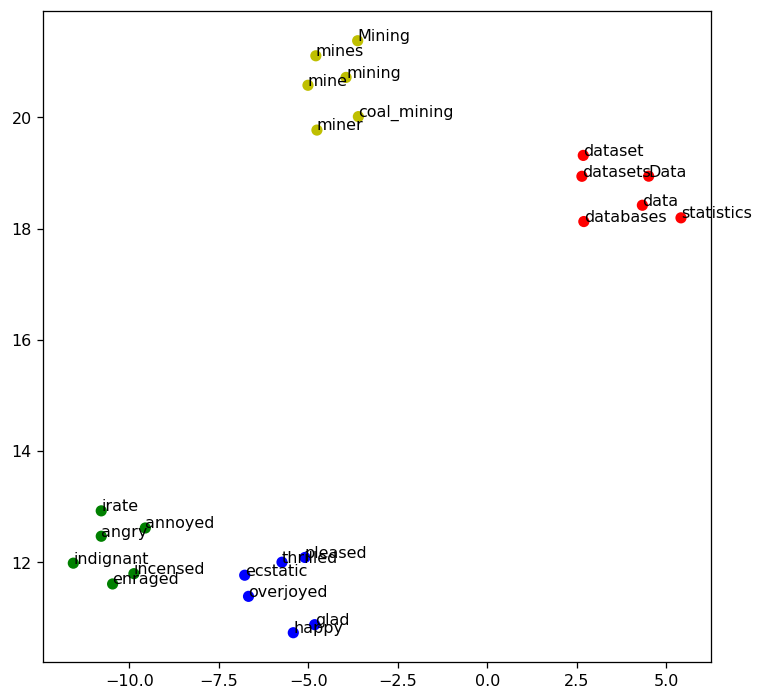

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.vocab.keys())
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [69]:
# Answer here
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = "GoogleNews/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)


load ok


[('glad', 0.7408890128135681),
 ('pleased', 0.6632171273231506),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049768447876),
 ('satisfied', 0.6437950134277344),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247666478157043)]

In [70]:
word_list = ['angry', 'happy', 'sad', 'fear']

topn = 15

angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
sad_words = ['sad'] + [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]        
fear_words = ['fear'] + [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]        

print('angry_words: ', angry_words)
print('happy_words: ', happy_words)
print('sad_words: ', sad_words)
print('fear_words: ', fear_words)

target_words = angry_words + happy_words + sad_words + fear_words
print('\ntarget words: ')
print(target_words)

cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn

angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
sad_words:  ['sad', 'saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet']
fear_words:  ['fear', 'fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']

target words: 
['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'e

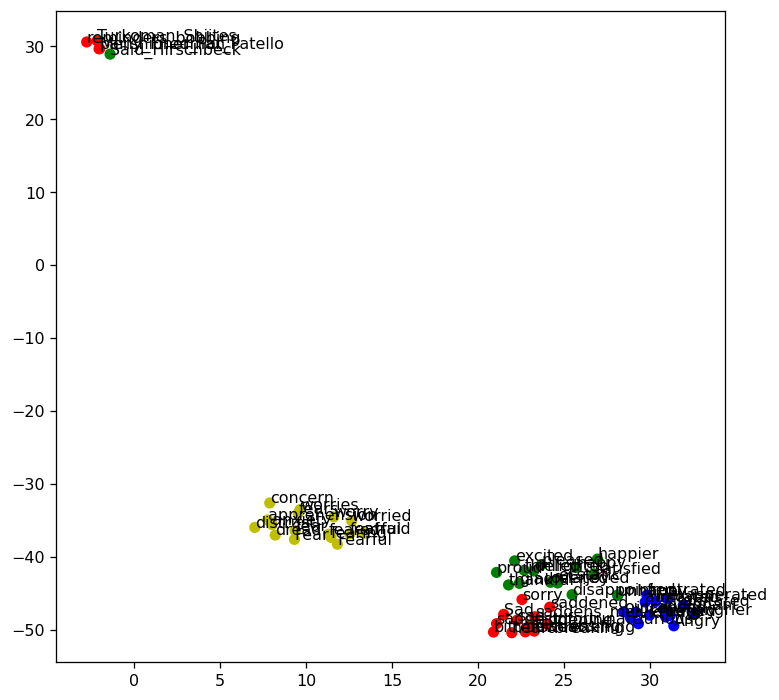

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# w2v model
model = w2v_google_model

# prepare training word vectors
size = 2000
target_size = len(target_words)
all_word = list(model.vocab.keys())
word_train = target_words + all_word[:size]
X_train = model[word_train]

# t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

# training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---